In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split

We are loading the Fashion MNIST dataset, which contains grayscale images of clothing items. The images are reshaped to add a channel dimension so they can be used in a CNN. Then, we split the original training data into 50,000 training images and 10,000 validation images. The stratify option makes sure the class distribution stays balanced during the split.

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train[..., tf.newaxis]  # (60000, 28, 28, 1)
x_test = x_test[..., tf.newaxis]

# Split into train (50k) and validation (10k)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=10000, random_state=42, stratify=y_train
)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import numpy as np

unique_labels = np.unique(y_train)
print("Label IDs:", unique_labels)

Label IDs: [0 1 2 3 4 5 6 7 8 9]


There are total 10 unique labels in this dataset that we will use for classification

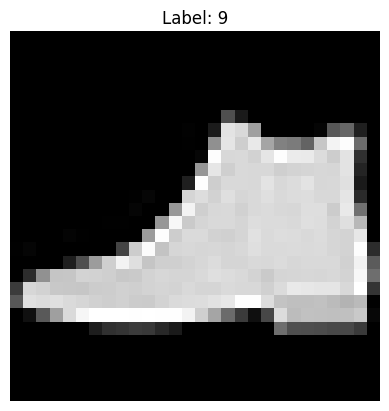

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0], cmap='gray')
plt.title(f"Label: {y_train[0]}")
plt.axis('off')
plt.show()


This code sets up a data pipeline using TensorFlow’s tf.data API to efficiently prepare image data for training a neural network. First, we define a preprocess_fn function that resizes each image to 224x224, converts grayscale images to RGB by copying the single channel to all three, and applies ResNet-specific preprocessing.

Then, we create a reusable function prepare_dataset that builds a pipeline for any given image and label set. It loads the data into a TensorFlow Dataset, applies the preprocessing function to each image, shuffles the data if it's for training, batches it into groups of 32, and prefetches batches for faster training.

Using this pipeline helps in handling large datasets more efficiently and ensures that preprocessing, batching, and loading are done in a way that keeps the GPU/CPU busy and training fast.

In [ ]:
def preprocess_fn(image, label):
    image = tf.image.resize(image, [224, 224])         # Resize to 224x224
    image = tf.image.grayscale_to_rgb(image)           # Convert 1 → 3 channels
    image = tf.cast(image, tf.float32)
    image = resnet_preprocess(image)                   # Apply ResNet preprocessing
    return image, label

# Create tf.data pipelines
BATCH_SIZE = 32

def prepare_dataset(images, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    ds = ds.map(preprocess_fn, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(1000)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = prepare_dataset(x_train, y_train, training=True)
val_ds = prepare_dataset(x_val, y_val)
test_ds = prepare_dataset(x_test, y_test)

* Loading the ResNet50 model with imagenet weights, set include_top=False, and specify the input shape as (224, 224, 3).

* Freezing the ResNet base by setting base_model.trainable = False.

* Then creating a sequential model by stacking: the base model, a global average pooling layer, a dense layer with 128 units and ReLU activation, a dropout layer, and a final dense layer with 10 units and softmax activation.


In [ ]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze backbone

# Add custom classification head
model_base = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # 10 Fashion-MNIST classes
])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


* The model is compiled using the Adam optimizer.

* The loss function used is 'sparse_categorical_crossentropy' (suitable for integer labels).

* The model will track accuracy as a performance metric during training and evaluation.

In [ ]:
model_base.compile(
    optimizer=optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Now training the model with 3 epochs

In [ ]:
history = model_base.fit(
    train_ds,
    epochs=3,
    validation_data=val_ds
)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 210s 122ms/step - accuracy: 0.7697 - loss: 0.6609 - val_accuracy: 0.8827 - val_loss: 0.3083
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 182s 115ms/step - accuracy: 0.8579 - loss: 0.3958 - val_accuracy: 0.8910 - val_loss: 0.2858
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 168s 106ms/step - accuracy: 0.8702 - loss: 0.3646 - val_accuracy: 0.8996 - val_loss: 0.2789


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate and collect metrics
def evaluate_model(model, test_ds, y_test, model_name="Model"):
    # Get predictions
    y_pred_probs = model.predict(test_ds)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Convert test labels to numpy (if not already)
    y_true = np.array(y_test)

    # Classification report
    report = classification_report(y_true, y_pred, output_dict=True)

    # Print & save metrics
    f1 = report['weighted avg']['f1-score']
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    accuracy = report['accuracy']

    print(f"== {model_name} Metrics ==")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return {"model": model_name, "accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


313/313 ━━━━━━━━━━━━━━━━━━━━ 52s 150ms/step
== Base Model Metrics ==
Accuracy : 0.8903
Precision: 0.8923
Recall   : 0.8903
F1 Score : 0.8910


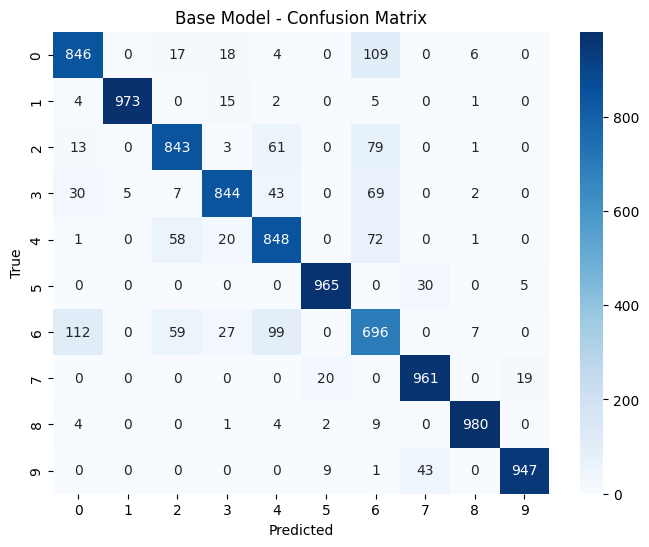

In [ ]:
metrics_base = evaluate_model(model_base, test_ds, y_test, model_name="Base Model")

* High True Positives: Most diagonal cells are strong, especially:
Class 1 (973), Class 5 (965), Class 8 (980), and Class 9 (947).

* Class 0 is often confused with Class 9 (109 times).

* Class 6 is confused with multiple classes, especially Class 0 (112 times) and Class 4 (99 times).

* Class 2 & 3 show moderate confusion with Class 4 (61 and 43 times respectively).


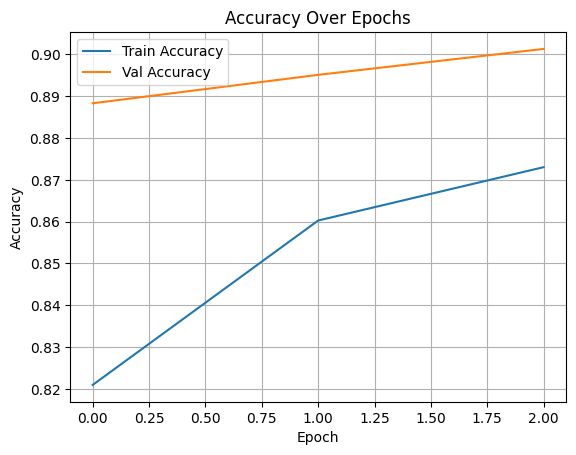

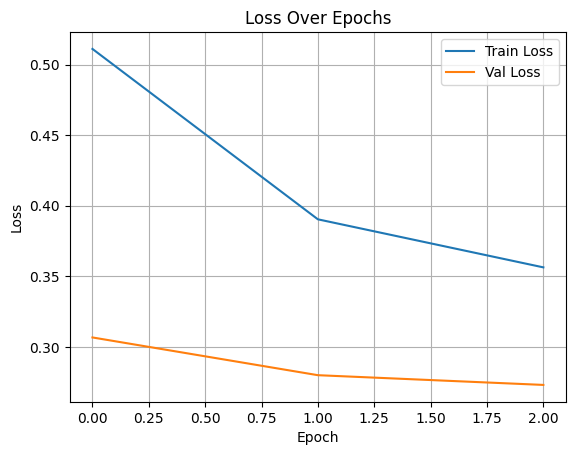

In [ ]:


# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Training Loss is steadily decreasing.

Validation Loss is also decreasing with a smaller slope.

There is no signs of overfitting after 3 epochs.

**Unfreeze only the last convolutional block**

In [ ]:
# Unfreeze the last ResNet block
for layer in base_model.layers:
    if 'conv5_block' in layer.name:
        layer.trainable = True

# Compile with lower LR
model_base.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune
fine_tune_history = model_base.fit(
    train_ds,
    epochs=3,  # Keep it low at first
    validation_data=val_ds
)


Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 268s 154ms/step - accuracy: 0.8674 - loss: 0.3936 - val_accuracy: 0.9212 - val_loss: 0.2196
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 253s 155ms/step - accuracy: 0.9159 - loss: 0.2352 - val_accuracy: 0.9308 - val_loss: 0.1989
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 230s 146ms/step - accuracy: 0.9349 - loss: 0.1803 - val_accuracy: 0.9315 - val_loss: 0.2045


313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 103ms/step
== Unfreezed model Metrics ==
Accuracy : 0.9270
Precision: 0.9275
Recall   : 0.9270
F1 Score : 0.9272


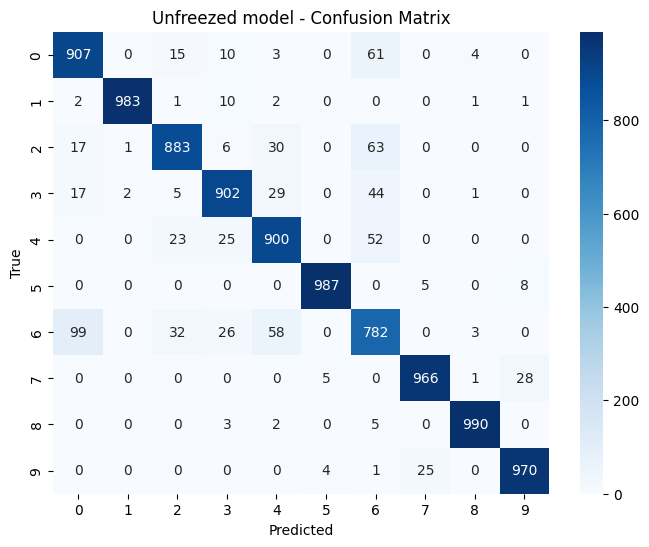

In [ ]:
metrics_base = evaluate_model(model_base, test_ds, y_test, model_name="Unfreezed model")

The unfreezed model outperforms the frozen one in all key metrics because it allowed more layers to be updated during training, which led to better feature learning and adaptation to your specific dataset.

most diagonal elements having values close to 900–990, indicating strong class-wise predictions.

Class 6 has misclassifications to class 0 (99 times), which is significant.

Class 0 also gets confused with class 6 (61 times).

Some confusion between class 3 and 4, 2 and 4.

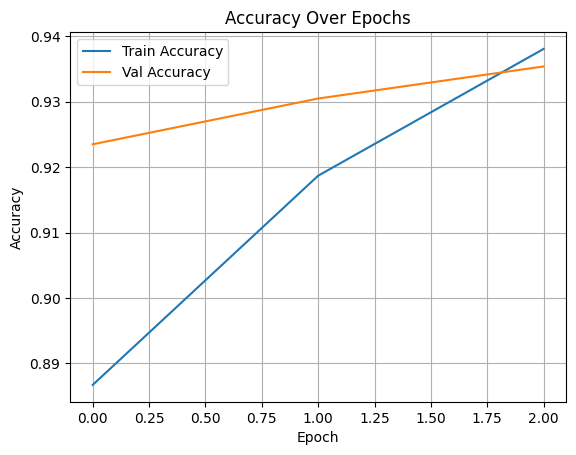

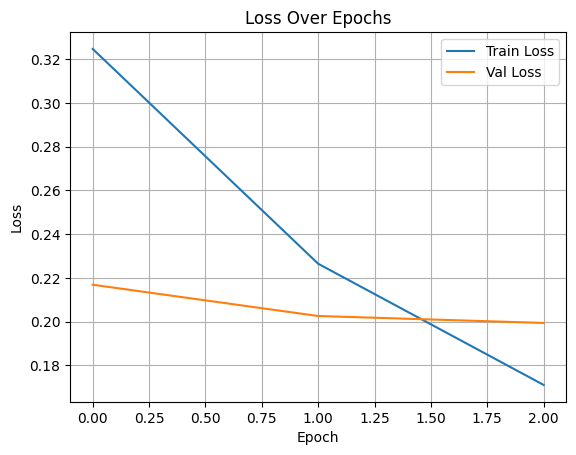

In [ ]:
# Plot accuracy
plt.plot(fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.plot(fine_tune_history.history['loss'], label='Train Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

No overfitting yet, though train-val loss gap is widening a bit.

**Using Data Augmentation for training data**

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

def preprocess_augmented(image, label):
    image = tf.image.resize(image, [224, 224])
    image = tf.image.grayscale_to_rgb(image)
    image = tf.cast(image, tf.float32)
    image = data_augmentation(image)
    image = resnet_preprocess(image)
    return image, label

train_ds_aug = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds_aug = train_ds_aug.map(preprocess_augmented, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_aug = train_ds_aug.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


* A Sequential model called data_augmentation is created with random horizontal flipping, slight rotation, and zooming to artificially expand the training data variety.

* The function preprocess_augmented resizes each image to 224×224 pixels, converts grayscale to RGB, casts it to float, and applies the augmentation pipeline.

* It also normalizes the image using resnet_preprocess, which prepares it for input to a ResNet model.

* A TensorFlow dataset train_ds_aug is created from the training data (x_train, y_train).

* The dataset is mapped through the preprocessing function, shuffled, batched, and preloaded using prefetch to improve performance during training.

In [ ]:
# Compile the model
model_base.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


# Train the model
history = model_base.fit(
    train_ds_aug,
    validation_data=val_ds,   # Make sure val_ds is defined and preprocessed similarly (but without augmentation)
    epochs=3
)


Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 743s 456ms/step - accuracy: 0.8479 - loss: 0.4541 - val_accuracy: 0.9316 - val_loss: 0.2054
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 720s 454ms/step - accuracy: 0.8997 - loss: 0.2855 - val_accuracy: 0.9323 - val_loss: 0.2057
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 722s 456ms/step - accuracy: 0.9099 - loss: 0.2556 - val_accuracy: 0.9365 - val_loss: 0.1952


313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 105ms/step
== Data Augmentation Metrics ==
Accuracy : 0.9266
Precision: 0.9273
Recall   : 0.9266
F1 Score : 0.9267


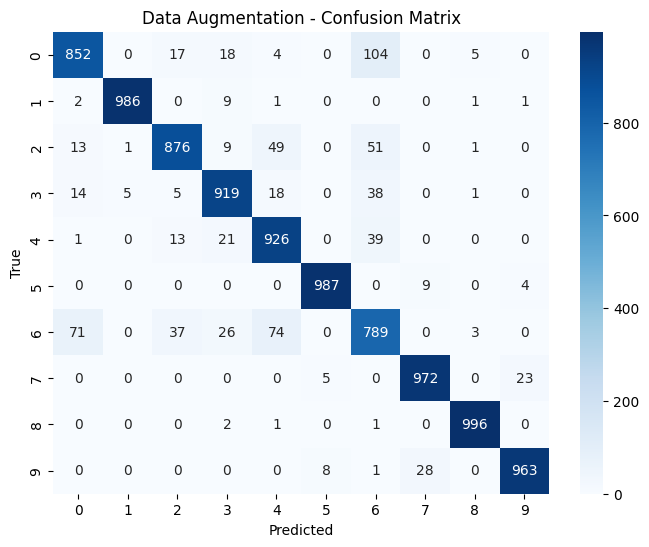

In [ ]:
metrics_base = evaluate_model(model_base, test_ds, y_test, model_name="Data Augmentation")

There is reduced misclassifications in digits like 6, 3, 4, and 9 when augmentation is used.

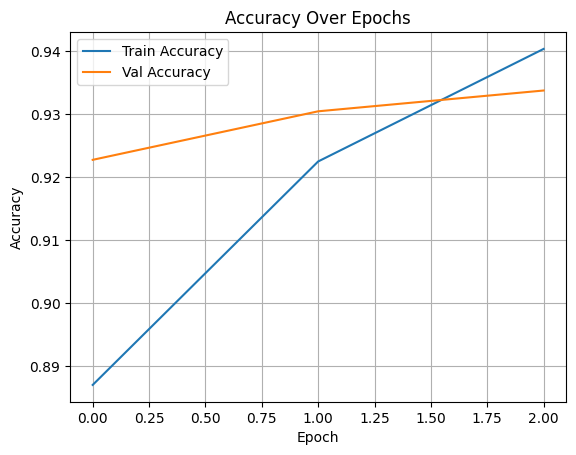

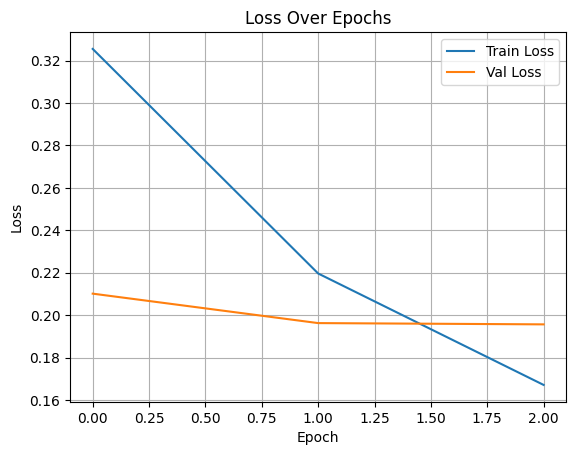

In [ ]:
# Plot accuracy
plt.plot(fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.plot(fine_tune_history.history['loss'], label='Train Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Without augmentation, the model only sees original data.

With augmentation, the model trains on rotated, shifted, zoomed, or noisy versions of digits it learns more variations of each class.

This improves robustness and reduces overfitting, as seen from the lower validation loss.

**Learning Rate Scheduling**

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model_base.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


* lr_schedule uses ExponentialDecay to reduce the learning rate over time — starting at 1e-4, it decays by a factor of 0.9 every 1000 steps.

* An Adam optimizer is created using this learning rate schedule, allowing the model to train more efficiently by adapting the learning rate.

In [ ]:
learning_rate_history = model_base.fit(
    train_ds,
    epochs=3,  # Keep it low at first
    validation_data=val_ds
)


Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 260s 152ms/step - accuracy: 0.9175 - loss: 0.2421 - val_accuracy: 0.9331 - val_loss: 0.1942
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 229s 145ms/step - accuracy: 0.9395 - loss: 0.1735 - val_accuracy: 0.9398 - val_loss: 0.1862
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 276s 155ms/step - accuracy: 0.9540 - loss: 0.1269 - val_accuracy: 0.9410 - val_loss: 0.1921


313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 103ms/step
== Learning Rate Scheduling Metrics ==
Accuracy : 0.9341
Precision: 0.9343
Recall   : 0.9341
F1 Score : 0.9340


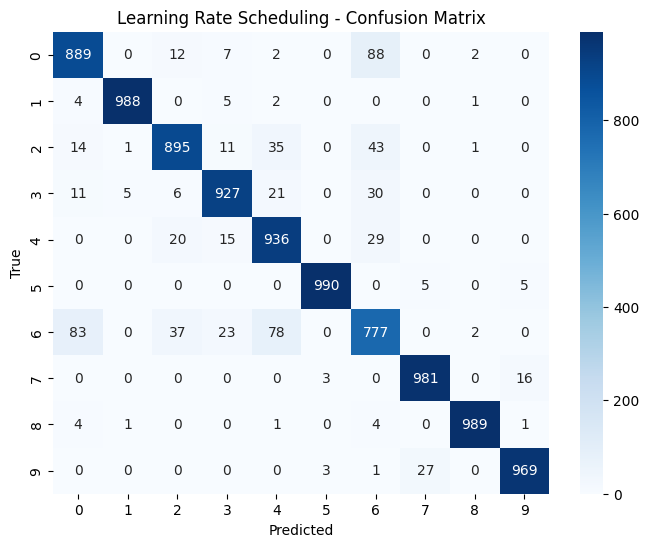

In [ ]:
metrics_base = evaluate_model(model_base, test_ds, y_test, model_name="Learning Rate Scheduling")

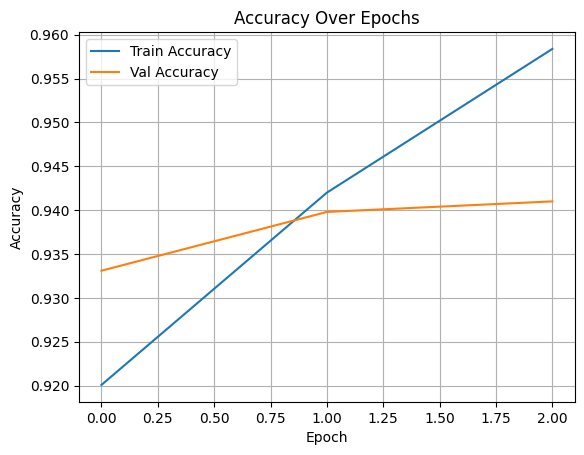

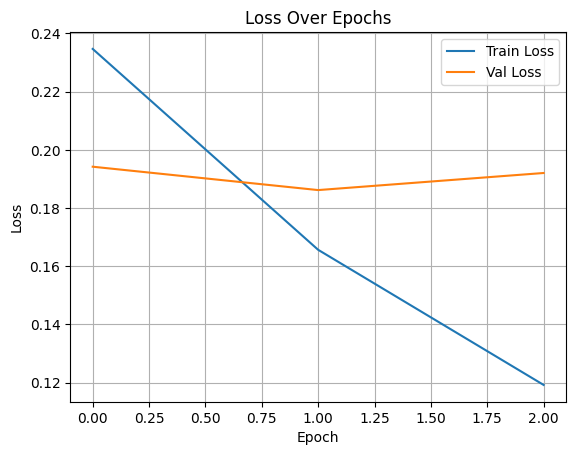

In [ ]:
plt.plot(learning_rate_history.history['accuracy'], label='Train Accuracy')
plt.plot(learning_rate_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.plot(learning_rate_history.history['loss'], label='Train Loss')
plt.plot(learning_rate_history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Accuracy has increased but there is a sign of overfitting since there is no augmentation and exponential decay reduces learning rate over time, potentially too early, making the model converge slower or get stuck in local minima.